In [1]:
from main_sbm import SBM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
import pickle as pkl
from collections import Counter
from eval import retrieve_samples
from igraph.clustering import compare_communities

def generate_graph_bicluster(Sr, Sc, thetas, random_seed = None, edge = "binary", undirected = False):
    # Kr = thetas.shape[0]
    # Kc = thetas.shape[1]

    N = np.sum(Sr)

    Hr = []
    c = 0
    for i in Sr:
        for j in range(i):
            Hr += [c]
        c+=1

    Hc = []
    c = 0
    for i in Sc:
        for j in range(i):
            Hc += [c]
        c+=1

    if isinstance(random_seed, int):
        np.random.seed(random_seed)

    X = np.zeros((N,N))
    if edge == "binary":
        for i in range(N):
            for j in range(N):
                if i == j:
                    continue
                X[i, j] = np.random.binomial(1, thetas[Hr[i], Hc[j]])
    elif edge == "weighted":
        for i in range(N):
            for j in range(N):
                if i == j:
                    continue
                X[i, j] = np.random.poisson(thetas[Hr[i], Hc[j]], 1)

    if undirected:
        X = np.triu(X) + np.triu(X).T

    return X

def cluster_summs(Z, ret = False):
    temp_Z = []
    mean_lenght = 0
    mean_nodes = 0
    for i in range(len(Z)):
        current_z = np.sum(Z[i], 0)
        temp_Z.append(current_z)
        mean_lenght += len(current_z)
        mean_nodes += np.mean(current_z)

    mean_lenght /= len(Z)
    mean_nodes /= len(Z)

    print('mean number of clusters', mean_lenght)
    print('mean nodes per cluster', mean_nodes)
    if ret:
        return temp_Z

In [2]:
def compute_VIs(C):
    N = len(C)
    VIs = np.zeros((N,N))

    for i in range(N):
        for j in range(i):
            VIs[i,j] = compare_communities(C[i], C[j])

    VIs += VIs.T

    return VIs

def compute_edge_quantities(X, zr, zc = None, mode = 'biclustering'):
    if mode == 'uniclustering':
        M1 = zr.T @ X @ zr
        X = X.copy().astype(int)
        X_rev = (np.where((X==0)|(X==1), X^1, X) - np.eye(X.shape[0])).copy() #reverse matrix for non_links
        M0 = zr.T @ X_rev @ zr


    if mode == 'biclustering':
        M1 = zr.T @ X @ zc

        X = X.copy().astype(int)
        X_rev = (np.where((X==0)|(X==1), X^1, X) - np.eye(X.shape[0])).copy() #reverse matrix for non_links
        M0 = zr.T @ X_rev @ zc

    return M1, M0

def compute_logL(X, zr, zc = None, a=1, b=1, mode = 'biclustering'):
    if mode == 'uniclustering':
        M1, M0 = compute_edge_quantities(X, zr, mode = 'uniclustering')
        

    if mode == 'biclustering':
        M1, M0 = compute_edge_quantities(X, zr, zc, mode = 'biclustering')
    
    logLlhood = np.sum(betaln(M1 + a, M0 + b) - betaln(a, b))
    return logLlhood

def compute_logLs(X, Z, mode = 'biclustering'):
    if mode == 'uniclustering':
        N = len(Z)
        logLs = [0]*N
        for i in range(N):
            logLs[i] = compute_logL(X, Z[i], mode = 'uniclustering')
    if mode == 'biclustering':
        N = len(Z[0])
        logLs = [0]*N
        for i in range(N):
            logLs[i] = compute_logL(X, Z[0][i], Z[1][i], mode = 'biclustering')

    return logLs

def compute_Zhat(X, Z, mode = 'biclustering', weight_llhood = False, ret_VI = False, ret_all = False):
    if mode == 'uniclustering':
        Z = retrieve_samples(Z, gap = 10)

        C = [np.where(x == 1)[1].tolist() for x in Z]

        VI = compute_VIs(C)
        VI = VI.sum(0)/VI.shape[0]

        if weight_llhood == True:
            logLs = compute_logLs(X, Z, mode = 'uniclustering')
            VI *= -logLs        

        idx_min = np.argmin(VI) 
        z_hat = Z[idx_min]
        c_hat = np.where(z_hat==1)[1]

    if mode == 'biclustering':
        Zr = retrieve_samples(Z[0], gap = 10)
        Zc = retrieve_samples(Z[1], gap = 10)

        Cr = [np.where(x == 1)[1].tolist() for x in Zr]
        Cc = [np.where(x == 1)[1].tolist() for x in Zc]

        VIr = compute_VIs(Cr)
        VIc = compute_VIs(Cc)

        VI = (VIr + VIc)/2
        VI = VI.sum(0)/VI.shape[0]

        if weight_llhood == True:
            logLs = compute_logLs(X, [Zr, Zc], mode = 'biclustering')
            VI *= -logLs

        idx_min = np.argmin(VI) 
        z_hat = [Zr[idx_min], Zc[idx_min]]
        c_hat = [np.where(z_hat[0]==1)[1], np.where(z_hat[1]==1)[1]]

    if ret_all:
        return [Zr, Zc], VI, idx_min

    if ret_VI:
        return z_hat, VI[idx_min]

    return z_hat

def compute_rhos(X, Z, a=1, b=1, edge_type = 'directed', edge_weight = 'binary', mode = 'normal'):
    rhos = np.zeros((len(X), len(X)))
    if mode == 'normal':    
        A = np.array([np.where(Z[i,:] == 1)[0] for i in range(len(Z))]).flatten()

        if edge_type == 'undirected':
            M1 = Z.T @ X @ Z - np.diag(np.sum(X@Z*Z, 0) / 2) 

            m = np.sum(Z, 0)[np.newaxis]

            M0 = m.T@m - np.diag((m*(m+1) / 2).flatten()) - M1 

        elif edge_type == 'directed':
            M1 = Z.T @ X @ Z

            m = np.sum(Z, 0)[np.newaxis]
            M0 = m.T@m - np.diag(m.flatten()) - M1

        for i in range(len(X)):
            for j in range(len(X)):
                if i == j:
                    continue
                links = M1[A[i], A[j]]
                non_links = M0[A[i], A[j]]
                rhos[i,j] += (links + a) / (links + non_links + a + b)

    elif mode == 'biclustering':
        zr = Z[0]
        zc = Z[1]
        cr = np.where(zr==1)[1]
        cc = np.where(zc==1)[1]

        M1 = zr.T @ X @ zc

        X_ = X.copy().astype(int)
        X_rev = (np.where((X_==0)|(X_==1), X_^1, X_) - np.eye(X_.shape[0])).copy() #reverse matrix for non_links

        M0 = zr.T @ X_rev @ zc

        for i in range(len(X)):
            for j in range(len(X)):
                if i == j:
                    continue
                links = M1[cr[i], cc[j]]
                non_links = M0[cr[i], cc[j]]
                rhos[i,j] += (links + a) / (links + non_links + a + b)
    return rhos

def compute_rho(X, sample, edge_type = 'directed', edge_weight = 'binary', mode = 'normal'):
    rhos = np.zeros((len(X), len(X)))
    if mode == 'normal':
        for i in sample:
            rhos += compute_rhos(X, i, edge_type = edge_type, edge_weight = edge_weight, mode = mode)
        rhos /= len(sample)
    if mode == 'biclustering':
        for i in range(len(sample[0])):
            rhos += compute_rhos(X, [sample[0][i], sample[1][i]], 
                            edge_type = edge_type, edge_weight = edge_weight, mode = mode)
        rhos /= len(sample[0])
    return rhos

def compute_predicted_thetas(Sr, Sc, rho):
    prob_matrix = np.zeros((len(Sr), len(Sc)))

    Sr_ = [0] + list(np.cumsum(Sr))
    Sc_ = [0] + list(np.cumsum(Sc))
    for i in range(len(Sr)):
        for j in range(len(Sc)):
            interaction_matrix = rho[Sr_[i]:Sr_[i+1], Sc_[j]:Sc_[j+1]]
            # if i == j:
            #     if len(interaction_matrix) == 1:
            #         continue
            #     prob_matrix[i,j] += np.sum(interaction_matrix)/(len(interaction_matrix)**2 - len(interaction_matrix))
            # else:
            # prob_matrix[i,j] += np.mean(interaction_matrix)
            prob_matrix[i,j] += np.average(interaction_matrix, weights=(interaction_matrix>0))

    return prob_matrix

In [3]:
# theta = np.array([[0.75, 0.25, 0.25, 0.25],
#                   [0.25, 0.75, 0.25, 0.25],
#                   [0.25, 0.25, 0.75, 0.25],
#                   [0.25, 0.25, 0.25, 0.75]])

# Sr = [15, 15, 15, 15]
# Sc = [15, 15, 15, 15]
n_clust = 5
theta = np.zeros((n_clust,n_clust)) + 0.25
np.fill_diagonal(theta, 0.75)

# Sr = [20]*n_clust
# Sc = [20]*n_clust

Sr = [20, 20, 20, 20, 20]
Sc = [20, 20, 20, 20, 20]

# Sr = [15, 15, 15, 15]
# Sc = [15, 15, 15, 15]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

N = np.sum(Sr)
true_rho = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        true_rho[i,j] += theta[z0[0][i], z0[1][j]]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40) #CASE 1

In [94]:
theta = np.array([[0.75, 0.25, 0.25, 0.75, 0.25],
                  [0.25, 0.75, 0.25, 0.25, 0.75],
                  [0.25, 0.25, 0.75, 0.25, 0.75],
                  [0.75, 0.25, 0.25, 0.75, 0.75],
                  [0.25, 0.75, 0.75, 0.75, 0.75]])

Sr = [20, 15, 10, 10, 8]
Sc = [20, 15, 10, 10, 8]
# n_clust = 5
# theta = np.zeros((n_clust,n_clust)) + 0.25
# np.fill_diagonal(theta, 0.75)

# Sr = [20]*n_clust
# Sc = [20]*n_clust

# Sr = [30, 30, 15, 15, 10]
# Sc = [30, 30, 15, 15, 10]

# Sr = [15, 15, 15, 15]
# Sc = [15, 15, 15, 15]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40) #CASE 2

In [96]:
theta = np.array([[0.75, 0.25, 0.75, 0.75, 0.25],
                  [0.25, 0.75, 0.25, 0.25, 0.75],
                  [0.75, 0.75, 0.25, 0.75, 0.75],
                  [0.75, 0.25, 0.25, 0.25, 0.25],
                  [0.75, 0.25, 0.25, 0.75, 0.75]])

Sr = [15, 15, 15, 15, 15]
Sc = [15, 15, 15, 15, 15]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40) #CASE 3

In [11]:
theta = np.array([[0.75, 0.25, 0.1, 0.9, 0.75],
                  [0.1, 0.75, 0.1, 0.1, 0.25],
                  [0.1, 0.75, 0.25, 0.9, 0.25],
                  [0.75, 0.9, 0.25, 0.25, 0.75]])

Sr = [25, 25, 25, 25]
Sc = [20, 20, 20, 20, 20]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40) #CASE 4

In [390]:
theta = np.array([[0.75, 0.25, 0.25, 0.9, 0.75, 0.75],
                  [0.25, 0.75, 0.25, 0.25, 0.25, 0.75],
                  [0.75, 0.75, 0.25, 0.9, 0.25, 0.75],
                  [0.75, 0.25, 0.25, 0.25, 0.75, 0.25]])

Sr = [30, 20, 15, 10]
Sc = [12, 13, 10, 13, 12, 15]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40) #CASE 5

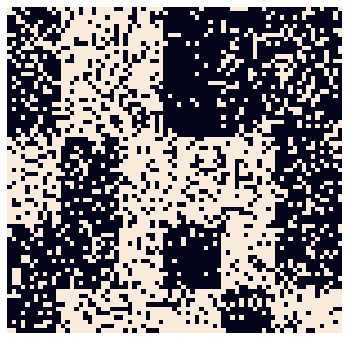

In [391]:
fig, ax = plt.subplots(figsize = (6,6))
ax = sns.heatmap(X, linewidth=0.0, ax = ax, cbar=False, cmap= 'rocket_r', xticklabels=[], yticklabels=[])
plt.show()

In [392]:
X_gt_theta = np.zeros((len(X), len(X)))
for i in range(len(X)):
    for j in range(len(X)):
        if i == j:
            continue
        X_gt_theta[i,j] = theta[z0[0][i], z0[1][j]]

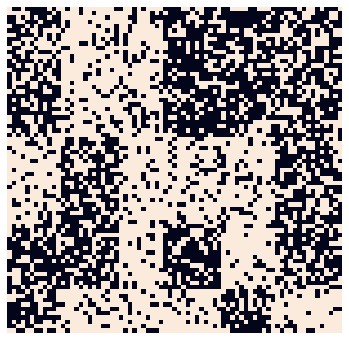

In [393]:
def train_val_split(data, valid_dim=0.2, random_seed = 42):
        '''
        Creating two additional objects, i.e. training and validation set, which can be used in the fitting process

        Parameters:
        data = np.array
        valid_dim = float
        '''
        if valid_dim >= 1:
          raise ValueError("valid_dim must be lower than 1")

        train = data.copy()
        valid = np.zeros(data.shape)

        np.random.seed(random_seed)

        for u in np.unique(data.nonzero()[0]):
            ind = data[u].nonzero()[0] 

            if len(ind) > 0: 
                valid_ind = np.random.choice(ind, round(len(ind)*valid_dim), replace=False)
                for i in valid_ind:
                    valid[u,i], train[u,i] = data[u,i], 0
        return train, valid

train, test = train_val_split(X, valid_dim = 0.2, random_seed= 30)
# model = esbmr()
# model.fit(train, 100)
# y_pred = model.predict(test)
fig, ax = plt.subplots(figsize = (6,6))
ax = sns.heatmap(train, linewidth=0.0, ax = ax, cbar=False, cmap= 'rocket_r', xticklabels=[], yticklabels=[])
plt.show()

In [243]:
np.sum(train)

2301.0

In [244]:
np.sum(test)

577.0

In [394]:
import numpy.ma as ma

In [395]:
test.astype("bool")

array([[False, False, False, ..., False, False, False],
       [False, False,  True, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [325]:
mask = np.invert(test.astype('bool'))

In [88]:
mx_X = ma.masked_array(X, mask = mask)

In [309]:
config = {'directed': True,
          'binary': True,
          'unicluster': True}
DP = SBM(config, alpha_PY_r=6, start_z="singleton", set_seed=42)
DP.fit(X,100)
print(cluster_summs(DP.Z[90:]))
Counter(np.argwhere(DP.Z[-1])[:,1])

# DP.fit(X, 10000)
# with open("results/Case1_DP_Z_unipartite.pickle", "wb") as f:
#     pkl.dump(DP.Z, f)

print(cluster_summs(DP.Z[len(DP.Z)//2:]))
print(Counter(np.argwhere(DP.Z[-1])[:,1]))

mean number of clusters 9.6
mean nodes per cluster 7.863636363636364
None
mean number of clusters 9.7
mean nodes per cluster 7.768181818181815
None
Counter({1: 13, 3: 13, 0: 12, 4: 10, 6: 9, 2: 5, 7: 5, 5: 5, 8: 2, 9: 1})


In [310]:
DP.evalZ(z0)
DP.compute_block_probabilities()
DP.predict()
np.sum(np.abs(X_gt_theta - DP.X_pred_theta))/(len(X)*(len(X)-1))

VI_rel_true:  0.559738474460999
VI_rel_ball:  0.11367240765126851
Kr
0.25:  9.0
0.50:  10.0
0.75:  10.0
Kc
0.25:  9.0
0.50:  10.0
0.75:  10.0


0.035440392272476265

In [311]:
DP.X_pred_theta

array([[0.        , 0.71428571, 0.71428571, ..., 0.71900826, 0.71900826,
        0.71900826],
       [0.71428571, 0.        , 0.71428571, ..., 0.71900826, 0.71900826,
        0.71900826],
       [0.71428571, 0.71428571, 0.        , ..., 0.71900826, 0.71900826,
        0.71900826],
       ...,
       [0.76033058, 0.76033058, 0.76033058, ..., 0.        , 0.16483516,
        0.16483516],
       [0.76033058, 0.76033058, 0.76033058, ..., 0.16483516, 0.        ,
        0.16483516],
       [0.76033058, 0.76033058, 0.76033058, ..., 0.16483516, 0.16483516,
        0.        ]])

In [312]:
DP.estimated_theta

array([[0.71428571, 0.24203822, 0.26229508, 0.24590164, 0.91082803,
        0.76033058, 0.73770492, 0.71900826, 0.8       ],
       [0.75796178, 0.26751592, 0.37878788, 0.28787879, 0.92941176,
        0.79389313, 0.60606061, 0.70992366, 0.7037037 ],
       [0.7704918 , 0.28787879, 0.42857143, 0.38461538, 0.95454545,
        0.62745098, 0.92307692, 0.70588235, 0.81818182],
       [0.31147541, 0.72727273, 0.26923077, 0.23809524, 0.28787879,
        0.17647059, 0.53846154, 0.54901961, 0.27272727],
       [0.24840764, 0.77647059, 0.21212121, 0.25757576, 0.2611465 ,
        0.29007634, 0.46969697, 0.53435115, 0.37037037],
       [0.79338843, 0.7480916 , 0.17647059, 0.2745098 , 0.88549618,
        0.20879121, 0.80392157, 0.75247525, 0.23809524],
       [0.68852459, 0.71212121, 0.34615385, 0.15384615, 0.90909091,
        0.25490196, 0.71428571, 0.74509804, 0.18181818],
       [0.76033058, 0.23664122, 0.2745098 , 0.2745098 , 0.22137405,
        0.77227723, 0.29411765, 0.16483516, 0.80952381],


In [313]:
DP.evalLogLikelihood_full()

-3127.356811516076

In [314]:
for i in DP.Z:
    print(DP.evalLogLikelihood_full(i))

-3226.188608315044
-3154.45778734731
-3131.8474658296627
-3131.3965942294076
-3134.538473256343
-3127.6152007869114
-3133.0182733928214
-3127.6152007869114
-3130.1330511287692
-3127.6152007869114
-3127.6152007869114
-3127.6152007869114
-3127.356811516076
-3127.356811516076
-3127.6152007869114
-3127.356811516076
-3127.356811516076
-3127.356811516076
-3127.6152007869114
-3127.6152007869114
-3127.356811516076
-3127.356811516076
-3127.356811516076
-3127.356811516076
-3127.6152007869114
-3127.356811516076
-3127.6152007869114
-3127.6152007869114
-3127.356811516076
-3129.5867624982898
-3130.1330511287692
-3127.6152007869114
-3127.6152007869114
-3127.356811516076
-3127.356811516076
-3127.6152007869114
-3127.6152007869114
-3129.5867624982898
-3134.5368751403425
-3127.6152007869114
-3127.6152007869114
-3127.356811516076
-3127.356811516076
-3127.356811516076
-3127.6152007869114
-3127.356811516076
-3127.6152007869114
-3127.356811516076
-3132.9725363896337
-3127.6152007869114
-3127.356811516076
-31

c:\Users\nakaz\Desktop\DSBA\TESI\BNP-Net\src\main_sbm.py:670: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zr == "none":


In [315]:
mask_X_gt = ma.masked_array(X_gt_theta, mask=mask)
mask_X_pred = ma.masked_array(DP.X_pred_theta, mask = mask)
np.sum(np.abs((mask_X_gt - mask_X_pred)))/np.sum(test)

0.03318338656165674

In [58]:
DP.fit(X, 1)

In [70]:
# print(cluster_summs(DP.Z[00:600]))
# DP.expected_cl(DP.N, 0, 3.5, np.Infinity)
# list_Z = cluster_summs(DP.Z, ret = True)
# np.quantile([len(x) for x in list_Z], 0.75)
# np.quantile([len(x) for x in list_Z], 0.5)

In [316]:
config = {'directed': True,
          'binary': True,
          'unicluster': False}
DP_bi = SBM(config, alpha_PY_r = 3, alpha_PY_c=3,
            start_z = "singleton", set_seed=42)
DP_bi.fit(train,200)

# DP_bi.fit(X, 10000)
# with open("results/Case4_DP_Z_bipartite_originalver.pickle", "wb") as f:
#     pkl.dump(DP_bi.Z, f)

print(cluster_summs(DP_bi.Zr[len(DP_bi.Zr)//2:]))
print(cluster_summs(DP_bi.Zc[len(DP_bi.Zc)//2:]))
print(Counter(np.argwhere(DP_bi.Zr[-1])[:,1]))
print(Counter(np.argwhere(DP_bi.Zc[-1])[:,1]))

mean number of clusters 5.51
mean nodes per cluster 14.016071428571431
None
mean number of clusters 8.33
mean nodes per cluster 9.220048701298703
None
Counter({0: 30, 1: 18, 2: 15, 3: 8, 4: 3, 5: 1})
Counter({3: 24, 0: 11, 4: 10, 1: 9, 5: 7, 2: 6, 6: 5, 7: 2, 8: 1})


In [342]:
DP_bi.evalZ(z0)
DP_bi.compute_block_probabilities()
DP_bi.predict()
np.sum(np.abs(X_gt_theta - DP_bi.X_pred_theta))/(len(X)*(len(X)-1))

VI_rel_true:  0.4950207736670048
VI_rel_ball:  0.6559164776310331
Kr
0.25:  5.0
0.50:  5.0
0.75:  6.0
Kc
0.25:  7.0
0.50:  8.0
0.75:  9.0


0.11128836458498656

In [343]:
DP_bi.evalZ(z0)
DP_bi.compute_block_probabilities()
DP_bi.predict()
np.sum(np.abs(X_gt_theta - DP_bi.X_pred_theta))/(len(X)*(len(X)-1))

VI_rel_true:  0.4950207736670048
VI_rel_ball:  0.6559164776310331
Kr
0.25:  5.0
0.50:  5.0
0.75:  6.0
Kc
0.25:  7.0
0.50:  8.0
0.75:  9.0


0.11128836458498656

In [172]:
DP_bi.estimated_theta

array([[0.11737089, 0.42545455, 0.32713755, 0.13811189, 0.19318182,
        0.43323727, 0.46666667],
       [0.12737921, 0.12068966, 0.3668942 , 0.31451613, 0.40425532,
        0.45867393, 0.1875    ],
       [0.12371134, 0.34931507, 0.35144312, 0.45322581, 0.2173913 ,
        0.13623978, 0.09677419],
       [0.13687601, 0.12522686, 0.0923913 , 0.38811189, 0.32183908,
        0.16842105, 0.26666667]])

In [173]:
mask_X_gt = ma.masked_array(X_gt_theta, mask=mask)
mask_X_pred = ma.masked_array(DP_bi.X_pred_theta, mask = mask)
np.sum(np.abs((mask_X_gt - mask_X_pred)))/np.sum(test)

0.18176133218810978

In [110]:
Counter(DP_bi.cc_hat)

Counter({5: 19, 1: 21, 2: 20, 0: 20, 4: 23, 3: 17})

In [72]:
DP_bi.fit(X,1)

In [396]:
config = {'directed': True,
          'binary': True,
          'unicluster': True}
PY = SBM(config, prior_r = "PY", alpha_PY_r=0.6,sigma_PY_r=-0.3, 
           start_z = "singleton", set_seed=42)
PY.fit(X,100)

# PY.fit(X, 10000)
# with open("results/Case4_PY_Z_unipartite.pickle", "wb") as f:
#     pkl.dump(PY.Z, f)

print(cluster_summs(PY.Z[len(PY.Z)//2:]))
print(Counter(np.argwhere(PY.Z[-1])[:,1]))

mean number of clusters 9.0
mean nodes per cluster 8.333333333333329
None
Counter({1: 13, 4: 13, 0: 12, 6: 10, 8: 10, 2: 5, 3: 5, 7: 5, 5: 2})


In [397]:
PY.evalZ(z0)
PY.compute_block_probabilities()
PY.predict()
print(PY.evalLogLikelihood_full())
np.sum(np.abs(X_gt_theta - PY.X_pred_theta))/(len(X)*(len(X)-1))

VI_rel_true:  0.5299736145971649
VI_rel_ball:  0.0
Kr
0.25:  9.0
0.50:  9.0
0.75:  9.0
Kc
0.25:  9.0
0.50:  9.0
0.75:  9.0
-3083.088752723324


0.03552972487191214

In [399]:
PY.evalLogLikelihood_full()

-3083.088752723324

In [353]:
mask_X_gt = ma.masked_array(X_gt_theta, mask=mask)
mask_X_pred = ma.masked_array(PY.X_pred_theta, mask = mask)
np.sum(np.abs((mask_X_gt - mask_X_pred)))/np.sum(test)

0.13510562761473216

In [74]:
PY.fit(X,1)

In [400]:
config = {'directed': True,
          'binary': True,
          'unicluster': False}
PY_bi = SBM(config, start_z = "singleton", set_seed=42,
         prior_r = "PY", alpha_PY_r=0.6,sigma_PY_r=-0.3,
         prior_c = "PY", alpha_PY_c=0.6,sigma_PY_c=-0.3)

PY_bi.fit(X,200)

# PY_bi.fit(X, 10000)
# with open("results/Case4_PY_Z_bipartite.pickle", "wb") as f:
#     pkl.dump(PY_bi.Z, f)

print(cluster_summs(PY_bi.Zr[len(PY_bi.Zr)//2:]))
print(cluster_summs(PY_bi.Zc[len(PY_bi.Zc)//2:]))
print(Counter(np.argwhere(PY_bi.Zr[-1])[:,1]))
print(Counter(np.argwhere(PY_bi.Zc[-1])[:,1]))

mean number of clusters 4.22
mean nodes per cluster 17.9375
None
mean number of clusters 6.22
mean nodes per cluster 12.111607142857142
None
Counter({0: 30, 1: 19, 2: 15, 3: 10, 4: 1})
Counter({3: 15, 1: 13, 4: 13, 0: 12, 5: 11, 2: 10, 6: 1})


In [401]:
PY_bi.evalZ(z0)
PY_bi.compute_block_probabilities()
PY_bi.predict()
print(PY_bi.evalLogLikelihood_full())
np.sum(np.abs(X_gt_theta - PY_bi.X_pred_theta))/(len(X)*(len(X)-1))

VI_rel_true:  0.02650393486306702
VI_rel_ball:  0.09285704238423609
Kr
0.25:  4.0
0.50:  4.0
0.75:  4.0
Kc
0.25:  6.0
0.50:  6.0
0.75:  6.0
-3026.6732189613836


0.018791580272626954

In [402]:
PY_bi.evalLogLikelihood_full()

-3026.6732189613836

In [364]:
Counter(PY_bi.cc_hat)

Counter({0: 12, 1: 13, 2: 10, 4: 13, 5: 12, 3: 15})

In [365]:
PY_bi.cr_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)

In [366]:
mask_X_gt = ma.masked_array(X_gt_theta, mask=mask)
mask_X_pred = ma.masked_array(PY_bi.X_pred_theta, mask = mask)
np.sum(np.abs((mask_X_gt - mask_X_pred)))/np.sum(test)

0.0177907382348028

In [267]:
PY_bi.fit(X,1)

In [268]:
config = {'directed': True,
          'binary': True,
          'unicluster': True}
DM = SBM(config, prior_r = "DM",beta_DM_r=3.5/50,K_DM_r=50,
            start_z = "singleton", set_seed=42)
DM.fit(train,100)

# DM.fit(X, 10000)
# with open("results/Case4_DM_Z_unipartite.pickle", "wb") as f:
#     pkl.dump(DM.Z, f)

print(cluster_summs(DM.Z[len(DM.Z)//2:]))
print(Counter(np.argwhere(DM.Z[-1])[:,1]))

KeyboardInterrupt: 

In [78]:
DM.fit(X,1)

In [79]:
config = {'directed': True,
          'binary': True,
          'unicluster': False}
DM_bi = SBM(config, start_z = "singleton", set_seed=42,
         prior_r = "DM", beta_DM_r=3.5/50, K_DM_r=50,
         prior_c = "DM", beta_DM_c=3.5/50, K_DM_c=50)
DM_bi.fit(X,500)

# DM_bi.fit(X, 10000)
# with open("results/Case4_DM_Z_bipartite.pickle", "wb") as f:
#     pkl.dump(DM_bi.Z, f)

print(cluster_summs(DM_bi.Zr[len(DM_bi.Zr)//2:]))
print(cluster_summs(DM_bi.Zc[len(DM_bi.Zc)//2:]))
print(Counter(np.argwhere(DM_bi.Zr[-1])[:,1]))
print(Counter(np.argwhere(DM_bi.Zc[-1])[:,1]))

mean number of clusters 5.1592
mean nodes per cluster 19.882555555555765
None
mean number of clusters 5.9866
mean nodes per cluster 17.104905483405616
None
Counter({3: 25, 2: 25, 0: 25, 1: 23, 4: 2})
Counter({0: 32, 3: 20, 1: 20, 2: 20, 4: 8})


In [80]:
DM_bi.fit(X,1)

In [375]:
config = {'directed': True,
          'binary': True,
          'unicluster': True}
GN = SBM(config, prior_r = "GN", gamma_GN_r=0.45,
            start_z = "singleton", set_seed=42)
GN.fit(train,50)

# GN.fit(X, 10000)
# with open("results/Case4_GN_Z_unipartite.pickle", "wb") as f:
#     pkl.dump(GN.Z, f)

print(cluster_summs(GN.Z[len(GN.Z)//2:]))
print(Counter(np.argwhere(GN.Z[-1])[:,1]))

mean number of clusters 8.96
mean nodes per cluster 8.375000000000002
None
Counter({1: 13, 4: 13, 0: 12, 5: 10, 7: 10, 2: 5, 3: 5, 6: 5, 8: 2})


In [376]:
GN.evalZ(z0)
GN.compute_block_probabilities()
GN.predict()
np.sum(np.abs(X_gt_theta - GN.X_pred_theta))/(len(X)*(len(X)-1))

VI_rel_true:  0.5331139506792342
VI_rel_ball:  0.0720897934186091
Kr
0.25:  9.0
0.50:  9.0
0.75:  9.0
Kc
0.25:  9.0
0.50:  9.0
0.75:  9.0


0.10937270807809053

In [377]:
len(GN.Z_sample)

25

In [378]:
def compute_psm(Z_samples):
    N = len(X)
    Z = Z_samples
    zs = [np.where(x==1)[1][:, np.newaxis] for x in Z]
    T = len(zs)
    cocluster = np.zeros((N,N), dtype = int)
    for i in range(T):
        cocluster += (zs[i] == zs[i].T)

    psm = cocluster/T
    return psm

In [379]:
psm = compute_psm(GN.Z_sample)

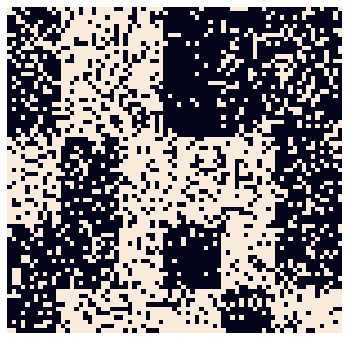

In [380]:
psm = compute_psm(GN.Z_sample)
fig, ax = plt.subplots(figsize = (6,6))
ax = sns.heatmap(X, linewidth=0.0, ax = ax, cbar=False, cmap= 'rocket_r', xticklabels=[], yticklabels=[])
plt.show()

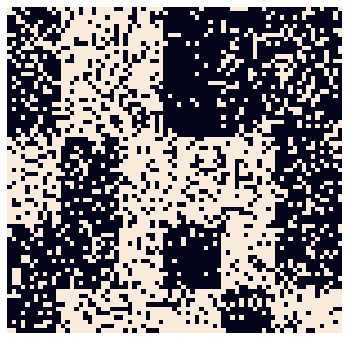

In [381]:
psm = compute_psm(GN.Z_sample)
fig, ax = plt.subplots(figsize = (6,6))
ax = sns.heatmap(X, linewidth=0.0, ax = ax, cbar=False, cmap= 'rocket_r', xticklabels=[], yticklabels=[])
plt.show()

In [382]:
psm

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [383]:
mask_X_gt = ma.masked_array(X_gt_theta, mask=mask)
mask_X_pred = ma.masked_array(GN.X_pred_theta, mask = mask)
np.sum(np.abs((mask_X_gt - mask_X_pred)))/np.sum(test)

0.13510562761473216

In [82]:
GN.fit(X,1)

In [374]:
config = {'directed': True,
          'binary': True,
          'unicluster': False}
GN_bi = SBM(config, start_z = "singleton", set_seed=42,
         prior_r = "GN", gamma_GN_r=0.45,
         prior_c = "GN", gamma_GN_c=0.45)
GN_bi.fit(train,100)

# GN_bi.fit(X, 10000)
# with open("results/Case4_GN_Z_bipartite.pickle", "wb") as f:
#     pkl.dump(GN_bi.Z, f)

print(cluster_summs(GN_bi.Zr[len(GN_bi.Zr)//2:]))
print(cluster_summs(GN_bi.Zc[len(GN_bi.Zc)//2:]))
print(Counter(np.argwhere(GN_bi.Zr[-1])[:,1]))
print(Counter(np.argwhere(GN_bi.Zc[-1])[:,1]))

mean number of clusters 4.0
mean nodes per cluster 18.75
None
mean number of clusters 6.0
mean nodes per cluster 12.5
None
Counter({0: 32, 1: 20, 2: 13, 3: 10})
Counter({5: 17, 2: 15, 0: 12, 4: 12, 1: 10, 3: 9})


In [384]:
GN_bi.evalZ(z0)
GN_bi.compute_block_probabilities()
GN_bi.predict()
np.sum(np.abs(X_gt_theta - GN_bi.X_pred_theta))/(len(X)*(len(X)-1))

VI_rel_true:  0.2203639331468027
VI_rel_ball:  0.3605956639718524
Kr
0.25:  4.0
0.50:  4.0
0.75:  4.0
Kc
0.25:  6.0
0.50:  6.0
0.75:  6.0


0.10921271483512465

In [385]:
mask_X_gt = ma.masked_array(X_gt_theta, mask=mask)
mask_X_pred = ma.masked_array(GN_bi.X_pred_theta, mask = mask)
np.sum(np.abs((mask_X_gt - mask_X_pred)))/np.sum(test)

0.1349149611721775

In [386]:
GN_bi.VIr_true

0.0

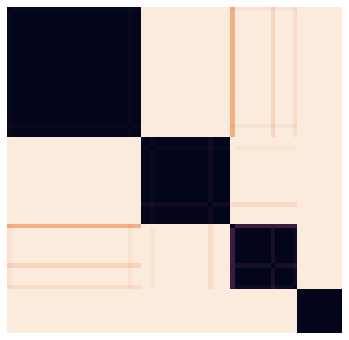

In [387]:
psm = compute_psm(GN_bi.Zr_sample)
fig, ax = plt.subplots(figsize = (6,6))
ax = sns.heatmap(psm, linewidth=0.0, ax = ax, cbar=False, cmap= 'rocket_r', xticklabels=[], yticklabels=[])
plt.show()

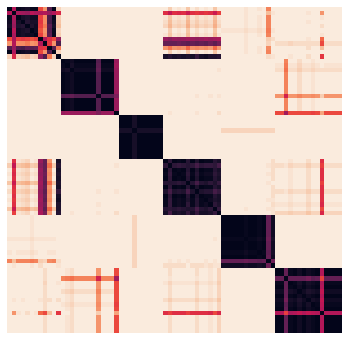

In [388]:
psm = compute_psm(GN_bi.Zc_sample)
fig, ax = plt.subplots(figsize = (6,6))
ax = sns.heatmap(psm, linewidth=0.0, ax = ax, cbar=False, cmap= 'rocket_r', xticklabels=[], yticklabels=[])
plt.show()

In [389]:
GN_bi.estimated_theta

array([[0.1984127 , 0.26013514, 0.68819599, 0.59106529, 0.64265928,
        0.5631929 ],
       [0.6091954 , 0.19897959, 0.23611111, 0.19900498, 0.20920502,
        0.59800664],
       [0.62755102, 0.14569536, 0.69911504, 0.62913907, 0.15204678,
        0.59728507],
       [0.19083969, 0.21782178, 0.1986755 , 0.63366337, 0.6446281 ,
        0.17021277]])

In [116]:
m = np.array([80,1])
gamma = 0.45
print(np.append((m + 1) * (np.sum(m) - len(m) + gamma), len(m)**2 - len(m)*gamma))
np.log(np.append((m + 1) * (np.sum(m) - len(m) + gamma), len(m)**2 - len(m)*gamma))

[6.43545e+03 1.58900e+02 3.10000e+00]


array([8.76957705, 5.06827507, 1.13140211])

In [405]:
from scipy.special import binom
from scipy.special import gammaln

In [440]:
# H = 50
N = 332
h = np.array([_ for _ in range(N)])
gamma = 0.

In [441]:
np.exp(np.sum(np.log(binom(N, h)) + gammaln(h - gamma) - gammaln(1 - gamma) + np.log(gamma) + gammaln(N + gamma - h) - gammaln(N + gamma)))

0.0

In [433]:
np.exp(np.log(binom(N, h)) + gammaln(h - gamma) - gammaln(1 - gamma) + np.log(gamma) + gammaln(N + gamma - h) - gammaln(N + gamma))

array([1.00000000e+00, 9.90029820e-01, 4.95029866e-03, 1.66665105e-03,
       8.37517610e-04, 5.04200973e-04, 3.36984623e-04, 2.41192107e-04,
       1.81201146e-04, 1.41139915e-04, 1.13056572e-04, 9.26064866e-05,
       7.72516508e-05, 6.54282504e-05, 5.61298515e-05, 4.86848222e-05,
       4.26309923e-05, 3.76418497e-05, 3.34813970e-05, 2.99756158e-05,
       2.69939045e-05, 2.44366939e-05, 2.22269985e-05, 2.03045350e-05,
       1.86215532e-05, 1.71398341e-05, 1.58284931e-05, 1.46623537e-05,
       1.36207259e-05, 1.26864796e-05, 1.18453341e-05, 1.10853071e-05,
       1.03962850e-05, 9.76968313e-06, 9.19817695e-06, 8.67548601e-06,
       8.19620039e-06, 7.75563974e-06, 7.34973827e-06, 6.97495041e-06,
       6.62817284e-06, 6.30667995e-06, 6.00806991e-06, 5.73021962e-06,
       5.47124673e-06, 5.22947762e-06, 5.00342021e-06, 4.79174081e-06,
       4.59324439e-06, 4.40685759e-06, 4.23161419e-06, 4.06664247e-06,
       3.91115438e-06, 3.76443604e-06, 3.62583956e-06, 3.49477581e-06,
      

In [431]:
np.sum(np.exp(np.log(binom(N, h)) + gammaln(h - gamma) - gammaln(1 - gamma) + np.log(gamma) + gammaln(N + gamma - h) - gammaln(N + gamma)))

1.9999998976487068

Link_Prediction

In [231]:
import pandas as pd

In [237]:
d = {}
d["PY"] = 1

In [239]:
d

{'PY': 1}

In [257]:
df = pd.DataFrame(0, index = ["PY_All", "PY_Test","GN_All", "GN_Test"], columns = [i/20 for i in range(20)])
df

,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
PY_All,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PY_Test,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GN_All,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GN_Test,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [258]:
missing_percents = [i/20 for i in range(20)]
for i, percent in enumerate(missing_percents):
    for t in range(10):
        df.iloc[0,i] += 1

In [259]:
df

,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
PY_All,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
PY_Test,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GN_All,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GN_Test,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
missing_percents = [i/20 for i in range(20)]

config_uni = {'directed': True,
          'binary': True,
          'unicluster': True}

config_bi = {'directed': True,
          'binary': True,
          'unicluster': False}
for i, percent in missing_percents:
    for j in range(10):
        train, test = train_val_split(X, valid_dim = i, random_seed= j)
        
        PY = SBM(config, prior_r = "PY", alpha_PY_r=0.6,sigma_PY_r=-0.3, 
                start_z = "singleton", set_seed=42)
        PY.fit(train,500)
        PY.compute_block_probabilities()
        PY.predict()
        df.iloc[0,i] += np.sum(np.abs((X_gt_theta - PY.X_pred_theta)))/(len(X)*(len(X)-1))

        mask_X_gt = ma.masked_array(X_gt_theta, mask=mask)
        mask_X_pred = ma.masked_array(PY_bi.X_pred_theta, mask = mask)
        np.sum(np.abs((mask_X_gt - mask_X_pred)))/np.sum(test)
        
        PY_bi = SBM(config, start_z = "singleton", set_seed=42,
         prior_r = "PY", alpha_PY_r=0.6,sigma_PY_r=-0.3,
         prior_c = "PY", alpha_PY_c=0.6,sigma_PY_c=-0.3)

        PY_bi.fit(train,500)
        PY_bi.compute_block_probabilities()
        PY_bi.predict()
        df.np.sum(np.abs(X_gt_theta - PY_bi.X_pred_theta))/(len(X)*(len(X)-1))


In [229]:
[i/20 for i in range(20)]

[0.0,
 0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95]

In [181]:
def evalZ(Z, z0):
    Zr = retrieve_samples(Z[0], gap = 10)
    Zc = retrieve_samples(Z[1], gap = 10)

    Cr = [np.where(x == 1)[1].tolist() for x in Zr]
    Cc = [np.where(x == 1)[1].tolist() for x in Zc]

    VIr = 0
    VIc = 0
    for i in range(len(Cr)):
        VIr += compare_communities(Cr[i], z0[0])
        VIc += compare_communities(Cc[i], z0[1])

    VIr = VIr/len(Cr)
    VIc = VIc/len(Cc)

    VI_relative_true = np.mean([VIr, VIc])

    Zsample, VI, idx_min = compute_Zhat(X, Z, mode = 'biclustering', ret_all = True)

    z_hat = [Zsample[0][idx_min], Zsample[1][idx_min]]
    c_hat = [np.where(z_hat[0]==1)[1], np.where(z_hat[1]==1)[1]]

    sorted_VI = VI[np.argsort(VI)]
    sorted_Zr = [Zsample[0][i] for i in np.argsort(VI)]
    sorted_Zc = [Zsample[1][i] for i in np.argsort(VI)]

    b_threshold = int(len(VI)*0.95)

    zr_ball = sorted_Zr[b_threshold]
    zc_ball = sorted_Zc[b_threshold]

    c_ball = [np.where(zr_ball==1)[1], np.where(zc_ball==1)[1]]

    VI_relative_ball = np.mean([compare_communities(c_hat[0], c_ball[0]), 
                                compare_communities(c_hat[1], c_ball[1])])

    VIr_true = compare_communities(c_hat[0], z0[0])
    VIc_true = compare_communities(c_hat[1], z0[1])

    print("VIr: ", VIr_true)
    print("VIc: ", VIc_true)
    print("VI_rel_true: ", VI_relative_true)
    print("VI_rel_ball: ", VI_relative_ball)


    Kr_vector = [i.shape[1] for i in sorted_Zr]
    Kc_vector = [i.shape[1] for i in sorted_Zc] 
    print("Kr")
    print('0.25: ', np.quantile(np.sort(Kr_vector), 0.25))
    print('0.50: ', np.quantile(np.sort(Kr_vector), 0.5))
    print('0.75: ', np.quantile(np.sort(Kr_vector), 0.75))

    print("Kc")
    print('0.25: ', np.quantile(np.sort(Kc_vector), 0.25))
    print('0.50: ', np.quantile(np.sort(Kc_vector), 0.5))
    print('0.75: ', np.quantile(np.sort(Kc_vector), 0.75))

    rho = compute_rho(X, Zsample, mode = 'biclustering')
    predicted_thetas = compute_predicted_thetas(Sr, Sc, rho)

    MAE = np.sum(np.abs(true_rho - rho))/(len(rho)**2 - len(rho))
    print("MAE: ", MAE)

    

Analysis:

Case 1:

In [200]:

n_clust = 5
theta = np.zeros((n_clust,n_clust)) + 0.25
np.fill_diagonal(theta, 0.75)

Sr = [20, 20, 20, 20, 20]
Sc = [20, 20, 20, 20, 20]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

N = np.sum(Sr)
true_rho = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        true_rho[i,j] += theta[z0[0][i], z0[1][j]]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40) #CASE 1

In [201]:
with open("results/Case1_DP_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)
print("\n")
with open("results/Case1_PY_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)

VIr:  0.0
VIc:  0.0
VI_rel_true:  0.001797561233461919
VI_rel_ball:  0.0
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.015527047474324202


VIr:  0.0
VIc:  0.0
VI_rel_true:  7.940609733834946e-05
VI_rel_ball:  0.0
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.015527637769108177


In [126]:
with open("results/Case1_DM_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)
print("\n")
with open("results/Case1_GN_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)

VIr:  0.0
VIc:  0.0
VI_rel_true:  0.0021945917201536664
VI_rel_ball:  0.039703048669174734
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.015526761498456521
VIr:  0.0
VIc:  0.0
VI_rel_true:  0.0
VI_rel_ball:  0.0
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.015527694964281713


In [202]:
with open("results/Case1_DP_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)
print("\n")
with open("results/Case1_PY_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)

VIr:  0.0
VIc:  0.0
VI_rel_true:  0.045661396554873265
VI_rel_ball:  0.1173199446673705
Kr
0.25:  5.0
0.50:  6.0
0.75:  6.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  6.0
MAE:  0.01612648460554333


VIr:  0.0
VIc:  0.0
VI_rel_true:  0.015581776138153595
VI_rel_ball:  0.06190753419815409
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.015772005930835026


In [204]:
with open("results/Case1_DM_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)
print("\n")
with open("results/Case1_GN_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)

VIr:  0.039703048669174734
VIc:  0.0
VI_rel_true:  0.07406041209007647
VI_rel_ball:  0.16387142717158532
Kr
0.25:  6.0
0.50:  6.0
0.75:  7.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  6.0
MAE:  0.016768512094353163


VIr:  0.0
VIc:  0.0
VI_rel_true:  0.0070818316124991836
VI_rel_ball:  0.03995315294014756
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.015722868113898697


In [205]:
theta = np.array([[0.75, 0.25, 0.25, 0.75, 0.25],
                  [0.25, 0.75, 0.25, 0.25, 0.75],
                  [0.25, 0.25, 0.75, 0.25, 0.75],
                  [0.75, 0.25, 0.25, 0.75, 0.75],
                  [0.25, 0.75, 0.75, 0.75, 0.75]])

Sr = [20, 15, 10, 10, 8]
Sc = [20, 15, 10, 10, 8]
# Sc = [15, 15, 15, 15]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

N = np.sum(Sr)
true_rho = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        true_rho[i,j] += theta[z0[0][i], z0[1][j]]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40) #CASE 2

In [206]:
print("DP: ")
with open("results/Case2_DP_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)
print("\nPY: ")
with open("results/Case2_PY_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)

DP: 
VIr:  0.11621114186919179
VIc:  0.11621114186919179
VI_rel_true:  0.19322489912477328
VI_rel_ball:  0.24700320524045605
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.02634419670993856

PY: 
VIr:  0.11621114186919179
VIc:  0.11621114186919179
VI_rel_true:  0.18767962097729968
VI_rel_ball:  0.19007331236801273
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.02628968141475012


In [185]:
print("DM: ")
with open("results/Case2_DM_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)
print("\nGN: ")
with open("results/Case2_GN_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)

DM: 
VIr:  0.11621114186919179
VIc:  0.11621114186919179
VI_rel_true:  0.1951130191062112
VI_rel_ball:  0.24555210346506096
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.02638518581576847

GN: 
VIr:  0.11621114186919179
VIc:  0.11621114186919179
VI_rel_true:  0.18681373287731734
VI_rel_ball:  0.19007331236801273
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.02631268524854733


In [209]:
with open("results/Case2_DP_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)
print("\n")
with open("results/Case2_PY_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)

VIr:  0.4629754954368046
VIc:  0.2918067096977355
VI_rel_true:  0.6422019685535041
VI_rel_ball:  0.6803561779539744
Kr
0.25:  6.0
0.50:  7.0
0.75:  8.0
Kc
0.25:  6.0
0.50:  7.0
0.75:  8.0
MAE:  0.047907153398820325


VIr:  0.4691607250949277
VIc:  0.4099292336339202
VI_rel_true:  0.5214320589530062
VI_rel_ball:  0.3557459186188463
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.04567115940860594


In [208]:
with open("results/Case2_DM_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)
print("\n")
with open("results/Case2_GN_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)

VIr:  0.4629754954368046
VIc:  0.44667123901968564
VI_rel_true:  0.6680479872654141
VI_rel_ball:  0.7313807967992765
Kr
0.25:  7.0
0.50:  8.0
0.75:  9.0
Kc
0.25:  6.0
0.50:  7.0
0.75:  8.0
MAE:  0.049038193837340587


VIr:  0.4629754954368046
VIc:  0.4099292336339202
VI_rel_true:  0.49713262018317905
VI_rel_ball:  0.47444843155697347
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.04492854657922441


In [210]:
theta = np.array([[0.75, 0.25, 0.75, 0.75, 0.25],
                  [0.25, 0.75, 0.25, 0.25, 0.75],
                  [0.75, 0.75, 0.25, 0.75, 0.75],
                  [0.75, 0.25, 0.25, 0.25, 0.25],
                  [0.75, 0.25, 0.25, 0.75, 0.75]])

Sr = [15, 15, 15, 15, 15]
Sc = [15, 15, 15, 15, 15]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

N = np.sum(Sr)
true_rho = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        true_rho[i,j] += theta[z0[0][i], z0[1][j]]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40) #CASE 3

In [211]:
print("DP: ")
with open("results/Case3_DP_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)
print("\nPY: ")
with open("results/Case3_PY_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)

DP: 
VIr:  0.0
VIc:  0.0
VI_rel_true:  0.013945401505659706
VI_rel_ball:  0.04898600535892683
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.020143055986398088

PY: 
VIr:  0.0
VIc:  0.0
VI_rel_true:  0.0019838807039651253
VI_rel_ball:  0.0
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.01991560807495949


In [215]:
print("DP: ")
with open("results/Case3_DM_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)
print("\nPY: ")
with open("results/Case3_GN_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)

DP: 
VIr:  0.0
VIc:  0.0
VI_rel_true:  0.01576799547475424
VI_rel_ball:  0.07853489344551079
Kr
0.25:  5.0
0.50:  5.0
0.75:  6.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  6.0
MAE:  0.02023393424344843

PY: 
VIr:  0.0
VIc:  0.0
VI_rel_true:  0.0
VI_rel_ball:  0.0
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.019909378250331282


In [213]:
with open("results/Case3_DP_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)
print("\n")
with open("results/Case3_PY_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)

VIr:  0.19594402143570866
VIc:  0.0
VI_rel_true:  0.2539071088385361
VI_rel_ball:  0.3002272383184683
Kr
0.25:  6.0
0.50:  7.0
0.75:  8.0
Kc
0.25:  6.0
0.50:  6.0
0.75:  7.0
MAE:  0.02811761763875129


VIr:  0.09886155921630513
VIc:  0.0
VI_rel_true:  0.16799198360584355
VI_rel_ball:  0.1870059787252496
Kr
0.25:  5.0
0.50:  5.5
0.75:  6.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.023958335591145213


In [214]:
with open("results/Case3_DM_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)
print("\n")
with open("results/Case3_GN_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)

VIr:  0.2144279462506411
VIc:  0.0
VI_rel_true:  0.2709682975858777
VI_rel_ball:  0.34778992349827464
Kr
0.25:  7.0
0.50:  7.0
0.75:  8.0
Kc
0.25:  6.0
0.50:  7.0
0.75:  7.0
MAE:  0.028890425510612976


VIr:  0.09886155921630513
VIc:  0.0
VI_rel_true:  0.14620111925777368
VI_rel_ball:  0.22733565047815452
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.02256050567385287


In [217]:
theta = np.array([[0.75, 0.25, 0.1, 0.9, 0.75],
                  [0.1, 0.75, 0.1, 0.1, 0.25],
                  [0.1, 0.75, 0.25, 0.9, 0.25],
                  [0.75, 0.9, 0.25, 0.25, 0.75]])

Sr = [25, 25, 25, 25]
Sc = [20, 20, 20, 20, 20]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

N = np.sum(Sr)
true_rho = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        true_rho[i,j] += theta[z0[0][i], z0[1][j]]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40) #CASE 4

In [218]:
print("DP: ")
with open("results/Case4_DP_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)
print("\nPY: ")
with open("results/Case4_PY_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)

DP: 
VIr:  0.5867070452737218
VIc:  0.36356349395951204
VI_rel_true:  0.4755541481900082
VI_rel_ball:  0.0
Kr
0.25:  8.0
0.50:  8.0
0.75:  8.0
Kc
0.25:  8.0
0.50:  8.0
0.75:  8.0
MAE:  0.019861563885623656

PY: 
VIr:  0.5867070452737218
VIc:  0.36356349395951204
VI_rel_true:  0.4752653028059749
VI_rel_ball:  0.0
Kr
0.25:  8.0
0.50:  8.0
0.75:  8.0
Kc
0.25:  8.0
0.50:  8.0
0.75:  8.0
MAE:  0.019858625366412842


In [219]:
with open("results/Case4_DM_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)
print("\n")
with open("results/Case4_GN_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)

VIr:  0.5867070452737218
VIc:  0.36356349395951204
VI_rel_true:  0.475944247758078
VI_rel_ball:  0.0
Kr
0.25:  8.0
0.50:  8.0
0.75:  8.0
Kc
0.25:  8.0
0.50:  8.0
0.75:  8.0
MAE:  0.01986536020522878


VIr:  0.5867070452737218
VIc:  0.36356349395951204
VI_rel_true:  0.47513526961661834
VI_rel_ball:  0.0
Kr
0.25:  8.0
0.50:  8.0
0.75:  8.0
Kc
0.25:  8.0
0.50:  8.0
0.75:  8.0
MAE:  0.019857932460046055


In [220]:
with open("results/Case4_DP_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)
print("\n")
with open("results/Case4_PY_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)

VIr:  0.0
VIc:  0.2840051164834252
VI_rel_true:  0.21074904513709167
VI_rel_ball:  0.24303905112445534
Kr
0.25:  4.0
0.50:  5.0
0.75:  6.0
Kc
0.25:  5.0
0.50:  6.0
0.75:  6.0
MAE:  0.017182975581791902


VIr:  0.0
VIc:  0.2375676348083089
VI_rel_true:  0.16289303746826503
VI_rel_ball:  0.15998135112893208
Kr
0.25:  4.0
0.50:  4.0
0.75:  4.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.01495700780784881


In [221]:
with open("results/Case4_DM_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)
print("\n")
with open("results/Case4_GN_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)

VIr:  0.0
VIc:  0.2840051164834252
VI_rel_true:  0.21955609564332143
VI_rel_ball:  0.2511849002749307
Kr
0.25:  5.0
0.50:  5.0
0.75:  6.0
Kc
0.25:  5.0
0.50:  6.0
0.75:  6.0
MAE:  0.017438836591718278


VIr:  0.0
VIc:  0.2375676348083089
VI_rel_true:  0.15573675535566936
VI_rel_ball:  0.16971559858855834
Kr
0.25:  4.0
0.50:  4.0
0.75:  4.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
MAE:  0.014646979007810236
